In [53]:
import os
import sys
import math
from functools import partial
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

from src.models import unet_2x, LFE, stacked_multi_scale
from src.config import *
ELEVATION_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/terrain/Colorado/train/tif'
MASK_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/terrain/Colorado/train/mask'

In [2]:
def load_subset(data_dir, N=None, frac=None, random=True, seed=1):
    '''
    Load a random subset of the images in a directory and return as an Nx256x256x1 numpy array
    '''
    np.random.seed(seed=seed)
    files = os.listdir(data_dir)
    if N:
        num_files = N
    elif frac:
        num_files = int(frac*len(files))
        
    if random:
        subset_files = np.random.choice(files, size=num_files, replace=False)
    else:
        subset_files = files[:num_files-1]
    
    data = []
    for fl in subset_files:
        im = Image.open(os.path.join(data_dir, fl))
        data.append(np.array(im))

    return np.expand_dims(np.stack(data), axis=3)

def stadardize(featurewise_std, batch):
    batch -= batch.mean(axis=(1,2), keepdims=True)
    batch /= featurewise_std
    print(batch.min(), batch.max())
    return batch

In [76]:
input_img = Input((*IMAGE_SIZE, 1), name='img')
# model = unet_2x(input_img, n_filters=8, dropout=0.0, batchnorm=False, logits=False)
model = stacked_multi_scale(input_img, n_filters=16, batchnorm=False, logits=False)

In [77]:
# load weights
model.load_weights('/Users/mikeskaug/Documents/personal/ridges/output/checkpoint/2020-03-24T21:35/weights.06-1.00.hdf5')

In [6]:
# prepare image generators
validation_fraction = 0.1
subset = load_subset(os.path.join(ELEVATION_TIF_DIR, 'sub'), frac=0.2)
featurewise_std = subset.std()
image_datagen = ImageDataGenerator(
    preprocessing_function=partial(stadardize, featurewise_std),
    validation_split=validation_fraction
)
# seed = 1
# images = load_subset(os.path.join(ELEVATION_TIF_DIR, 'sub'), frac=0.2)
# image_datagen.fit(images, augment=True, seed=seed)


In [78]:
# predict
predict_batch = load_subset(os.path.join(ELEVATION_TIF_DIR, 'sub'), N=10)
masks = load_subset(os.path.join(MASK_TIF_DIR, 'sub'), N=10)
normalized_predict_batch = image_datagen.standardize(predict_batch)
predictions = model.predict_on_batch(normalized_predict_batch)


-0.85818845 1.2103667


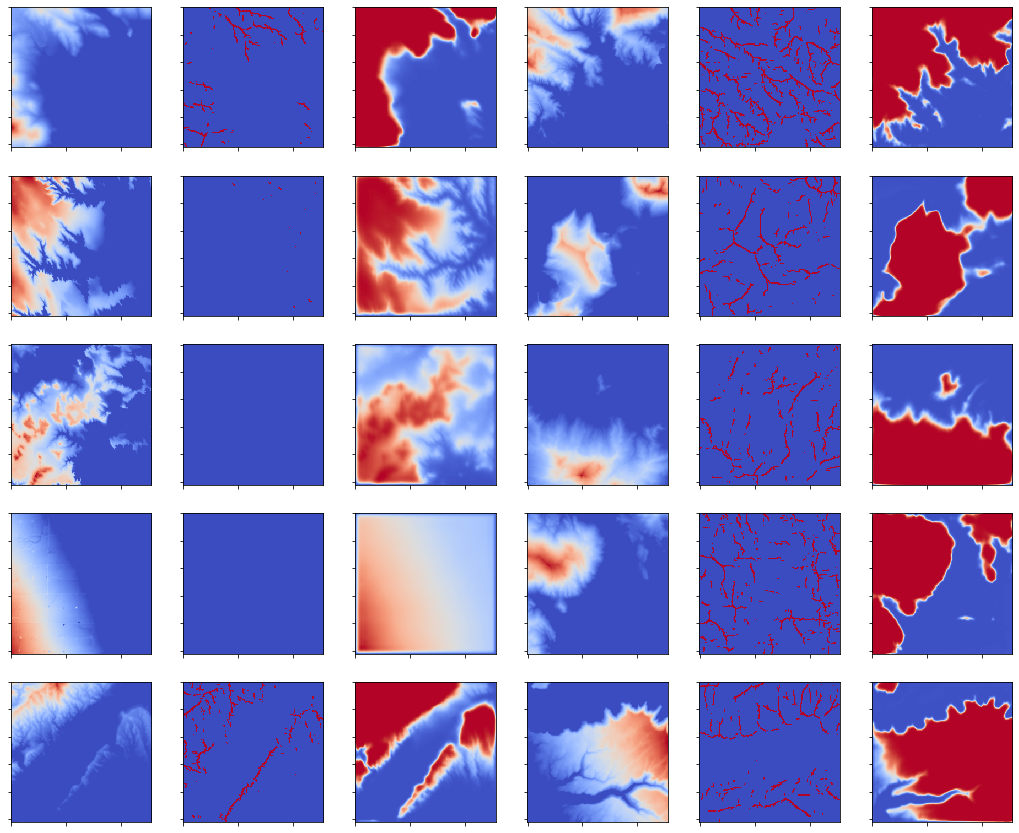

In [79]:
all_images = np.empty((30,256,256,1), dtype=predictions.dtype)
all_images[0::3,:,:,:] = normalized_predict_batch
all_images[1::3,:,:,:] = masks
all_images[2::3,:,:,:] = predictions

grid_width = 6
grid_height = int(all_images.shape[0] / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(18, 15))
for i in range(grid_height*grid_width):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow((all_images[i, :, :, :].reshape((256, 256))), cmap='coolwarm', vmin=0, )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.imshow(pred, alpha=0.3, cmap="OrRd")